# Experiment

In [1]:
import numpy as np
import sys
from util import utility_functions

import logging
logging.basicConfig(stream=sys.stdout, format='%(asctime)s | %(name)s (%(levelname)s):\t %(message)s')

In [2]:
from util.constants import JointFeatureMode


repitition_num = 10
parametrizations = utility_functions.get_parameterization_saps()
features = utility_functions.get_features_saps()
running_time = utility_functions.get_run_times_saps()
context_dimensions = 4
for index in range(
    (features.shape[1] + parametrizations.shape[1]) - 2
):
    context_dimensions = context_dimensions + 3 + index
    
context_matrix = utility_functions.get_context_matrix(
    parametrizations=parametrizations,
    features=features,
    joint_feature_map_mode=JointFeatureMode.POLYNOMIAL.value,
    context_feature_dimensions=context_dimensions,
)

## Self Sparring

In [3]:
regret_iss = np.zeros((repitition_num, features.shape[0]))
execution_time_iss = np.zeros(repitition_num)

In [7]:
import matplotlib.pyplot as plt
from util.metrics import compute_cumulative_regret
def plot_iss(regret_iss, size):
    cum_reg = compute_cumulative_regret(regret_iss)
    cum_reg_ucb = compute_cumulative_regret(np.load(f"Regret_results_theta0/regret_UCB_saps_{size}.npy", allow_pickle=True))
    cum_reg_colstim = compute_cumulative_regret(np.load(f"Regret_results_theta0/regret_Colstim_saps_{size}.npy", allow_pickle=True))
    cum_reg_colstim_v2 = compute_cumulative_regret(np.load(f"Regret_results_theta0/regret_Colstim_v2_saps_{size}.npy", allow_pickle=True))
    plt.plot(np.mean(cum_reg, axis=0), color='yellow', label="Self Sparring")
    plt.plot(np.mean(cum_reg_ucb, axis=0), color='red', label="UCB")
    plt.plot(np.mean(cum_reg_colstim, axis=0), color='blue', label="Colstim")
    plt.plot(np.mean(cum_reg_colstim_v2, axis=0), color='green', label="Colstim_v2")
    plt.title(f"k = {size}")
    plt.legend()
    plt.show()

Size: 5
Rep no.: 1
2022-11-10 14:30:40,800 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:30:40,802 | IndependentSelfSparring (INFO):	 Initializing...
Running algorithm...


100%|██████████| 5000/5000 [00:02<00:00, 1937.73it/s]

Algorithm Finished...
Rep no.: 2
2022-11-10 14:30:43,386 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:30:43,388 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:02<00:00, 1937.06it/s]

Algorithm Finished...
Rep no.: 3
2022-11-10 14:30:45,974 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:30:45,975 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:02<00:00, 1948.20it/s]

Algorithm Finished...
Rep no.: 4
2022-11-10 14:30:48,545 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:30:48,547 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:02<00:00, 1930.79it/s]

Algorithm Finished...
Rep no.: 5
2022-11-10 14:30:51,140 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:30:51,142 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:02<00:00, 1947.60it/s]

Algorithm Finished...
Rep no.: 6
2022-11-10 14:30:53,713 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:30:53,715 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:02<00:00, 1962.71it/s]

Algorithm Finished...
Rep no.: 7
2022-11-10 14:30:56,266 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:30:56,267 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:02<00:00, 1968.00it/s]

Algorithm Finished...
Rep no.: 8
2022-11-10 14:30:58,812 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:30:58,813 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:02<00:00, 1964.84it/s]

Algorithm Finished...
Rep no.: 9
2022-11-10 14:31:01,362 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:31:01,363 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:02<00:00, 1982.86it/s]

Algorithm Finished...
Rep no.: 10
2022-11-10 14:31:03,889 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:31:03,890 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:02<00:00, 1945.80it/s]


Algorithm Finished...


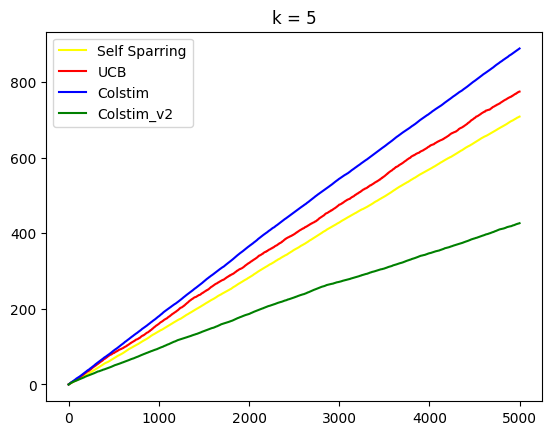

Size: 6
Rep no.: 1
2022-11-10 14:31:06,742 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:31:06,743 | IndependentSelfSparring (INFO):	 Initializing...
Running algorithm...


100%|██████████| 5000/5000 [00:02<00:00, 1767.17it/s]

Algorithm Finished...
Rep no.: 2
2022-11-10 14:31:09,576 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:31:09,577 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:02<00:00, 1763.93it/s]

Algorithm Finished...
Rep no.: 3
2022-11-10 14:31:12,416 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:31:12,418 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:02<00:00, 1776.08it/s]

Algorithm Finished...
Rep no.: 4
2022-11-10 14:31:15,238 | BaseAlgorithm (INFO):	 Initializing...


2022-11-10 14:31:15,240 | IndependentSelfSparring (INFO):	 Initializing...
Running algorithm...


100%|██████████| 5000/5000 [00:02<00:00, 1785.77it/s]

Algorithm Finished...
Rep no.: 5
2022-11-10 14:31:18,045 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:31:18,046 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:02<00:00, 1789.53it/s]

Algorithm Finished...
Rep no.: 6
2022-11-10 14:31:20,845 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:31:20,846 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:02<00:00, 1777.24it/s]

Algorithm Finished...
Rep no.: 7
2022-11-10 14:31:23,666 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:31:23,668 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:02<00:00, 1787.71it/s]

Algorithm Finished...
Rep no.: 8
2022-11-10 14:31:26,470 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:31:26,472 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:02<00:00, 1773.99it/s]

Algorithm Finished...
Rep no.: 9
2022-11-10 14:31:29,295 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:31:29,296 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:02<00:00, 1686.93it/s]

Algorithm Finished...
Rep no.: 10
2022-11-10 14:31:32,264 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:31:32,265 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:02<00:00, 1688.68it/s]


Algorithm Finished...


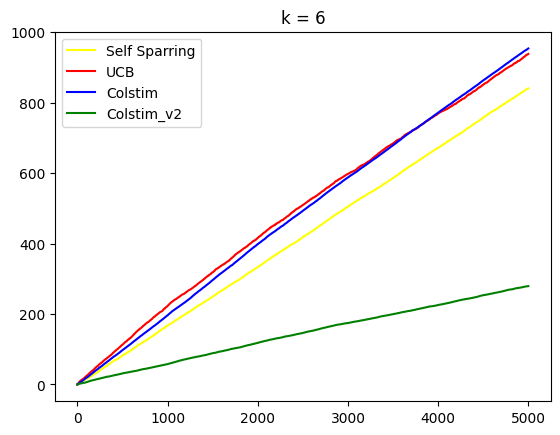

Size: 7
Rep no.: 1
2022-11-10 14:31:35,521 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:31:35,523 | IndependentSelfSparring (INFO):	 Initializing...
Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1606.66it/s]

Algorithm Finished...
Rep no.: 2
2022-11-10 14:31:38,640 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:31:38,641 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1609.24it/s]

Algorithm Finished...
Rep no.: 3
2022-11-10 14:31:41,752 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:31:41,753 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1600.54it/s]

Algorithm Finished...
Rep no.: 4
2022-11-10 14:31:44,882 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:31:44,883 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1606.90it/s]

Algorithm Finished...
Rep no.: 5
2022-11-10 14:31:47,998 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:31:48,000 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1604.64it/s]

Algorithm Finished...
Rep no.: 6
2022-11-10 14:31:51,120 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:31:51,122 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1613.04it/s]

Algorithm Finished...
Rep no.: 7
2022-11-10 14:31:54,226 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:31:54,227 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1603.86it/s]

Algorithm Finished...
Rep no.: 8
2022-11-10 14:31:57,348 | BaseAlgorithm (INFO):	 Initializing...


2022-11-10 14:31:57,350 | IndependentSelfSparring (INFO):	 Initializing...
Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1609.16it/s]

Algorithm Finished...
Rep no.: 9
2022-11-10 14:32:00,462 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:32:00,463 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1610.35it/s]

Algorithm Finished...
Rep no.: 10
2022-11-10 14:32:03,572 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:32:03,574 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1612.35it/s]


Algorithm Finished...


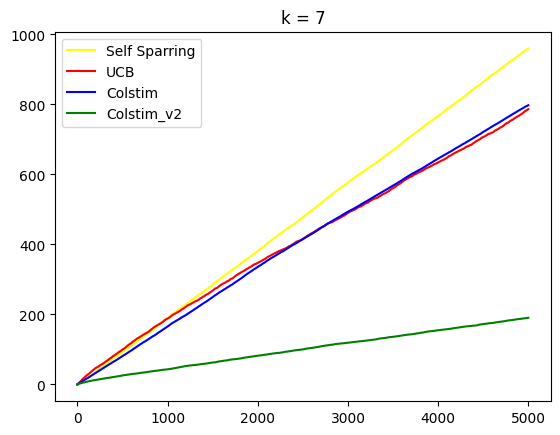

Size: 8
Rep no.: 1
2022-11-10 14:32:06,956 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:32:06,957 | IndependentSelfSparring (INFO):	 Initializing...
Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1454.16it/s]

Algorithm Finished...
Rep no.: 2
2022-11-10 14:32:10,400 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:32:10,401 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1452.59it/s]

Algorithm Finished...
Rep no.: 3
2022-11-10 14:32:13,847 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:32:13,849 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1447.52it/s]

Algorithm Finished...
Rep no.: 4
2022-11-10 14:32:17,307 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:32:17,309 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1451.19it/s]

Algorithm Finished...
Rep no.: 5
2022-11-10 14:32:20,759 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:32:20,762 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1455.38it/s]

Algorithm Finished...
Rep no.: 6
2022-11-10 14:32:24,201 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:32:24,203 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1462.78it/s]

Algorithm Finished...
Rep no.: 7
2022-11-10 14:32:27,625 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:32:27,626 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1452.69it/s]

Algorithm Finished...
Rep no.: 8
2022-11-10 14:32:31,072 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:32:31,073 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1455.01it/s]

Algorithm Finished...
Rep no.: 9
2022-11-10 14:32:34,514 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:32:34,515 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1457.78it/s]

Algorithm Finished...
Rep no.: 10
2022-11-10 14:32:37,949 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:32:37,950 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1460.16it/s]


Algorithm Finished...


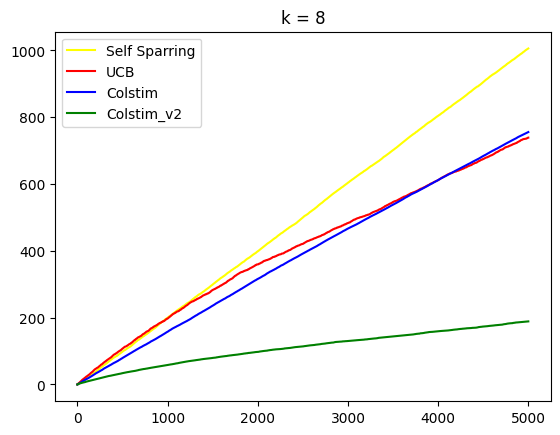

Size: 9
Rep no.: 1
2022-11-10 14:32:41,667 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:32:41,669 | IndependentSelfSparring (INFO):	 Initializing...
Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1319.22it/s]

Algorithm Finished...
Rep no.: 2
2022-11-10 14:32:45,463 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:32:45,464 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1320.94it/s]

Algorithm Finished...
Rep no.: 3
2022-11-10 14:32:49,253 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:32:49,255 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1315.50it/s]

Algorithm Finished...
Rep no.: 4
2022-11-10 14:32:53,061 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:32:53,063 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1285.46it/s]

Algorithm Finished...
Rep no.: 5
2022-11-10 14:32:56,957 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:32:56,959 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1316.72it/s]

Algorithm Finished...
Rep no.: 6
2022-11-10 14:33:00,760 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:33:00,762 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1319.31it/s]

Algorithm Finished...
Rep no.: 7
2022-11-10 14:33:04,556 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:33:04,557 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1321.51it/s]

Algorithm Finished...
Rep no.: 8
2022-11-10 14:33:08,345 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:33:08,346 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1320.94it/s]

Algorithm Finished...
Rep no.: 9
2022-11-10 14:33:12,135 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:33:12,137 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1321.87it/s]

Algorithm Finished...
Rep no.: 10
2022-11-10 14:33:15,923 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:33:15,924 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:03<00:00, 1324.01it/s]


Algorithm Finished...


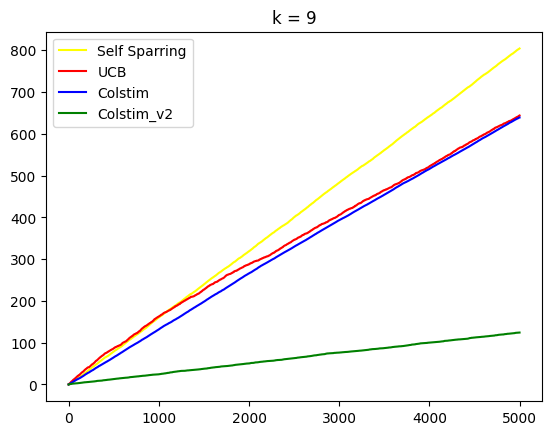

Size: 10
Rep no.: 1
2022-11-10 14:33:20,013 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:33:20,014 | IndependentSelfSparring (INFO):	 Initializing...
Running algorithm...


100%|██████████| 5000/5000 [00:04<00:00, 1203.67it/s]

Algorithm Finished...
Rep no.: 2
2022-11-10 14:33:24,173 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:33:24,174 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:04<00:00, 1203.81it/s]

Algorithm Finished...
Rep no.: 3
2022-11-10 14:33:28,331 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:33:28,333 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:04<00:00, 1203.25it/s]

Algorithm Finished...
Rep no.: 4
2022-11-10 14:33:32,493 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:33:32,494 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:04<00:00, 1206.35it/s]

Algorithm Finished...
Rep no.: 5
2022-11-10 14:33:36,642 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:33:36,644 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:04<00:00, 1205.04it/s]

Algorithm Finished...
Rep no.: 6
2022-11-10 14:33:40,796 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:33:40,798 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:04<00:00, 1202.93it/s]

Algorithm Finished...
Rep no.: 7
2022-11-10 14:33:44,958 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:33:44,959 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:04<00:00, 1198.26it/s]

Algorithm Finished...
Rep no.: 8
2022-11-10 14:33:49,136 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:33:49,137 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:04<00:00, 1201.88it/s]

Algorithm Finished...
Rep no.: 9
2022-11-10 14:33:53,302 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:33:53,306 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:04<00:00, 1201.62it/s]

Algorithm Finished...
Rep no.: 10
2022-11-10 14:33:57,471 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:33:57,473 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:04<00:00, 1205.52it/s]


Algorithm Finished...


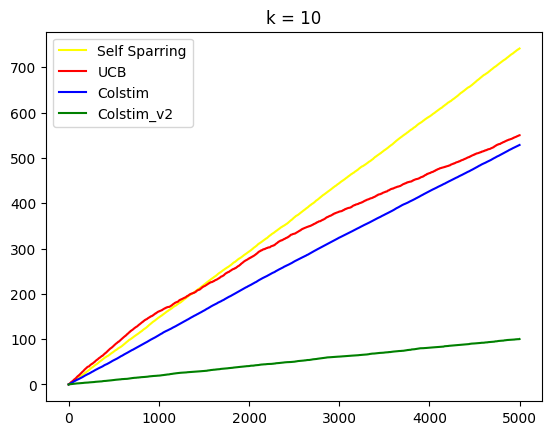

Size: 16
Rep no.: 1
2022-11-10 14:34:01,932 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:34:01,934 | IndependentSelfSparring (INFO):	 Initializing...
Running algorithm...


100%|██████████| 5000/5000 [00:06<00:00, 740.12it/s]

Algorithm Finished...
Rep no.: 2
2022-11-10 14:34:08,693 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:34:08,695 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:06<00:00, 737.60it/s]

Algorithm Finished...
Rep no.: 3
2022-11-10 14:34:15,477 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:34:15,479 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:06<00:00, 737.06it/s]

Algorithm Finished...
Rep no.: 4
2022-11-10 14:34:22,268 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:34:22,269 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:06<00:00, 741.98it/s]

Algorithm Finished...
Rep no.: 5
2022-11-10 14:34:29,011 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:34:29,013 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:06<00:00, 741.18it/s]

Algorithm Finished...
Rep no.: 6
2022-11-10 14:34:35,763 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:34:35,764 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:06<00:00, 739.77it/s]

Algorithm Finished...
Rep no.: 7
2022-11-10 14:34:42,526 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:34:42,528 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:06<00:00, 736.20it/s]

Algorithm Finished...
Rep no.: 8
2022-11-10 14:34:49,323 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:34:49,325 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:06<00:00, 737.00it/s]

Algorithm Finished...
Rep no.: 9
2022-11-10 14:34:56,113 | BaseAlgorithm (INFO):	 Initializing...


2022-11-10 14:34:56,116 | IndependentSelfSparring (INFO):	 Initializing...
Running algorithm...


100%|██████████| 5000/5000 [00:06<00:00, 735.28it/s]

Algorithm Finished...
Rep no.: 10
2022-11-10 14:35:02,920 | BaseAlgorithm (INFO):	 Initializing...
2022-11-10 14:35:02,923 | IndependentSelfSparring (INFO):	 Initializing...


Running algorithm...


100%|██████████| 5000/5000 [00:06<00:00, 739.78it/s]


Algorithm Finished...


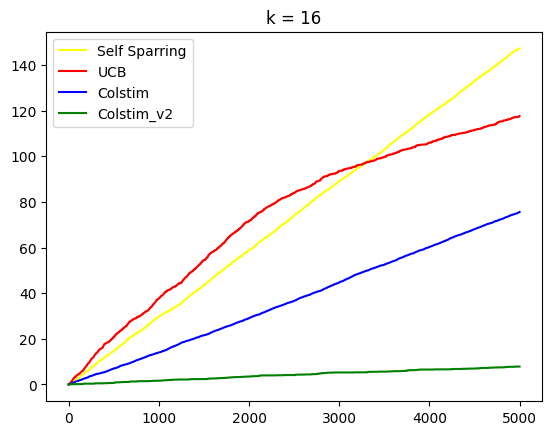

In [9]:
from algorithms import IndependentSelfSparring

for size in [5, 6, 7, 8, 9, 10, 16]:
    print(f"Size: {size}")
    for rep in range(repitition_num):
        print(f"Rep no.: {rep + 1}")
        iss = IndependentSelfSparring(random_state=np.random.RandomState(515), parametrizations=parametrizations, features=features, running_time=running_time, context_dimensions=context_dimensions, context_matrix=context_matrix, subset_size=size)
        iss.run()
        regret_iss[rep] = iss.get_regret()
        execution_time_iss[rep] = iss.execution_time
    plot_iss(regret_iss=regret_iss, size=size)

## Upper Confidence Bound (baseline)

In [3]:
regret_ucb = np.zeros((repitition_num, features.shape[0]))
execution_time_ucb = np.zeros(repitition_num)

In [4]:
from algorithms import UCB
for rep in range(repitition_num):
    print(f"Rep no.: {rep + 1}")
    ucb = UCB(random_state=np.random.RandomState(515), parametrizations=parametrizations, features=features, running_time=running_time, context_dimensions=context_dimensions, context_matrix=context_matrix, subset_size=2)
    ucb.run()
    regret_ucb[rep] = ucb.get_regret()
    execution_time_ucb[rep] = ucb.execution_time
    # np.save('regret_UCB_saps_16', regret_ucb)

Rep no.: 1
2022-11-08 10:46:01,512 | BaseAlgorithm (INFO):	 Initializing...
Running algorithm...


100%|██████████| 5000/5000 [05:40<00:00, 14.69it/s]

Algorithm Finished...


## CoLSTIM


In [5]:
regret_colstim = np.zeros((repitition_num, features.shape[0]))
execution_time_colstim = np.zeros(repitition_num)

In [ ]:
from algorithms import Colstim
for rep in range(repitition_num):
    print(f"Rep no.: {rep + 1}")
    colstim = Colstim(random_state=np.random.RandomState(515), parametrizations=parametrizations, features=features, running_time=running_time, context_dimensions=context_dimensions, context_matrix=context_matrix, subset_size=2)
    colstim.run()
    regret_colstim[rep] = colstim.get_regret()
    execution_time_colstim[rep] = colstim.execution_time

### Colstim_v2

In [ ]:
regret_colstim_v2 = np.zeros((repitition_num, features.shape[0]))
execution_time_colstim_v2 = np.zeros(repitition_num)

In [ ]:
from algorithms import Colstim_v2
for rep in range(repitition_num):
    print(f"Rep no.: {rep + 1}")
    colstim_v2 = Colstim_v2(random_state=np.random.RandomState(515), parametrizations=parametrizations, features=features, running_time=running_time, context_dimensions=context_dimensions, context_matrix=context_matrix, subset_size=2)
    colstim_v2.run()
    regret_colstim_v2[rep] = colstim_v2.get_regret()
    execution_time_colstim_v2[rep] = colstim_v2.execution_time

## Thompson Sampling


In [3]:
import matplotlib.pyplot as plt
from util.metrics import compute_cumulative_regret
def plot_ts(regret_ts, size):
    cum_reg = compute_cumulative_regret(regret_ts)
    cum_reg_ucb = compute_cumulative_regret(np.load(f"Regret_results_theta0/regret_UCB_saps_{size}.npy", allow_pickle=True))
    cum_reg_colstim = compute_cumulative_regret(np.load(f"Regret_results_theta0/regret_Colstim_saps_{size}.npy", allow_pickle=True))
    cum_reg_colstim_v2 = compute_cumulative_regret(np.load(f"Regret_results_theta0/regret_Colstim_v2_saps_{size}.npy", allow_pickle=True))
    plt.plot(np.mean(cum_reg, axis=0), color='yellow', label="Thompson Sampling")
    plt.plot(np.mean(cum_reg_ucb, axis=0), color='red', label="UCB")
    plt.plot(np.mean(cum_reg_colstim, axis=0), color='blue', label="Colstim")
    plt.plot(np.mean(cum_reg_colstim_v2, axis=0), color='green', label="Colstim_v2")
    plt.title(f"k = {size}")
    plt.legend()


In [7]:
regret_ts = np.zeros((repitition_num, features.shape[0]))
execution_time_ts = np.zeros(repitition_num)

In [8]:
from algorithms import ThompsonSampling

for rep in range(repitition_num):
    print(f"Rep no.: {rep + 1}")
    ts = ThompsonSampling(random_state=np.random.RandomState(515), parametrizations=parametrizations, features=features, running_time=running_time, context_dimensions=context_dimensions, context_matrix=context_matrix, subset_size=2)
    ts.run()
    regret_ts[rep] = ts.get_regret()
    execution_time_ts[rep] = ts.execution_time

Rep no.: 1
2022-11-08 10:53:23,550 | ThompsonSampling (INFO):	 Initializing...
2022-11-08 10:53:23,553 | ThompsonSampling (INFO):	 Initializing...
Running algorithm...


100%|██████████| 5000/5000 [00:02<00:00, 2375.88it/s]

Algorithm Finished...


# Plots

In [1]:
from util.constants import Solver
from util.metrics import compute_cumulative_regret
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_regret_curves(algorithms, solvers, subset_size, colors, directory, theta_0=False, single_solver=False):
    fig, ax = plt.subplots(len(solvers), len(subset_size), figsize=(30, 7), constrained_layout=True)
    for solver_index, solver in enumerate(solvers):
        for size_index, size in enumerate(subset_size):
            for index, algorithm in enumerate(algorithms):
                regret = np.load(f"{directory}//regret_{algorithm}_{solver}_{size}.npy", allow_pickle=True)
                cum_reg = compute_cumulative_regret(regret)
                if not single_solver:
                    ax[solver_index, size_index].plot(np.log(np.mean(cum_reg, axis=0)), color=colors[index], label=f"{algorithm}")
                    # ax[solver_index, size_index].fill_between(
                    #     range(len(cum_reg[0])), 
                    #     np.log(np.mean(cum_reg, axis=0)-np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
                    #     np.log(np.mean(cum_reg, axis=0)+np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
                    #     color=colors[index],
                    #     alpha=0.2
                    # )
                    ax[solver_index, size_index].legend()
                    ax[solver_index, size_index].set_ylabel("Logarithmic Cumulative Regret")
                    ax[solver_index, size_index].set_xlabel("Time")
                    ax[solver_index, size_index].set_title(f"N: 20, Solver: {solver}, Subset Size: {size}")
                else:
                    ax[size_index].plot(np.log(np.mean(cum_reg, axis=0)), color=colors[index], label=f"{algorithm}")
                    # ax[size_index].fill_between(
                    #     range(len(cum_reg[0])), 
                    #     np.log(np.mean(cum_reg, axis=0)-np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
                    #     np.log(np.mean(cum_reg, axis=0)+np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
                    #     color=colors[index],
                    #     alpha=0.2
                    # )
                    ax[size_index].legend()
                    ax[size_index].set_ylabel("Logarithmic Cumulative Regret")
                    ax[size_index].set_xlabel("Time")
                    ax[size_index].set_title(f"N: 20, Solver: {solver}, Subset Size: {size}")
    if theta_0:
        fig.suptitle('Logarithmic Cumulative regrets with initial theta = 0', fontsize=16)
    else:
        fig.suptitle('Logarithmic Cumulative regrets with random initial theta', fontsize=16)
    plt.show()

    fig, ax = plt.subplots(len(solvers), len(subset_size), figsize=(30, 7), constrained_layout=True)
    for solver_index, solver in enumerate(solvers):
        for size_index, size in enumerate(subset_size):
            for index, algorithm in enumerate(algorithms):
                regret = np.load(f"{directory}//regret_{algorithm}_{solver}_{size}.npy", allow_pickle=True)
                cum_reg = compute_cumulative_regret(regret)
                if not single_solver:
                    ax[solver_index, size_index].plot(np.mean(cum_reg, axis=0), color=colors[index], label=f"{algorithm}")
                    # ax[solver_index, size_index].fill_between(
                    #     range(len(cum_reg[0])), 
                    #     np.log(np.mean(cum_reg, axis=0)-np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
                    #     np.log(np.mean(cum_reg, axis=0)+np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
                    #     color=colors[index],
                    #     alpha=0.2
                    # )
                    ax[solver_index, size_index].legend()
                    ax[solver_index, size_index].set_ylabel("Cumulative Regret")
                    ax[solver_index, size_index].set_xlabel("Time")
                    ax[solver_index, size_index].set_title(f"N: 20, Solver: {solver}, Subset Size: {size}")
                else:
                    ax[size_index].plot(np.mean(cum_reg, axis=0), color=colors[index], label=f"{algorithm}")
                    # ax[size_index].fill_between(
                    #     range(len(cum_reg[0])), 
                    #     np.log(np.mean(cum_reg, axis=0)-np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
                    #     np.log(np.mean(cum_reg, axis=0)+np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
                    #     color=colors[index],
                    #     alpha=0.2
                    # )
                    ax[size_index].legend()
                    ax[size_index].set_ylabel("Cumulative Regret")
                    ax[size_index].set_xlabel("Time")
                    ax[size_index].set_title(f"N: 20, Solver: {solver}, Subset Size: {size}")
    if theta_0:
        fig.suptitle('Cumulative regrets with initial theta = 0', fontsize=16)
    else:
        fig.suptitle('Cumulative regrets with random initial theta', fontsize=16)
    plt.show()  

def plot_execution_times(algorithms, solvers, subset_size, colors, directory, single_solver=False):
    fig, ax = plt.subplots(len(solvers), len(subset_size), figsize=(30, 7), constrained_layout=True)
    if not single_solver:
        for solver_index, solver in enumerate(solvers):
            for size_index, size in enumerate(subset_size):
                for index, algorithm in enumerate(algorithms):
                    execution_time = np.load(f"{directory}//execution_time_{algorithm}_{solver}_{size}.npy")
                    ax[solver_index, size_index].bar(x=algorithm, height=execution_time.mean(), color=colors[index], label=f"{algorithm}")
                # ax[solver_index, size_index].fill_between(
                #     range(len(cum_reg[0])), 
                #     np.log(np.mean(cum_reg, axis=0)-np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
                #     np.log(np.mean(cum_reg, axis=0)+np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
                #     color=colors[index],
                #     alpha=0.2
                # )
                    ax[solver_index, size_index].legend()
                    ax[solver_index, size_index].set_ylabel("Mean execution time")
                    ax[solver_index, size_index].set_xlabel("Algorithms")
                    ax[solver_index, size_index].set_title(f"Solver: {solver}, Subset Size: {size}")
                ax[solver_index, size_index].grid()
    else:
        for solver_index, solver in enumerate(solvers):
            for size_index, size in enumerate(subset_size):
                for index, algorithm in enumerate(algorithms):
                    execution_time = np.load(f"{directory}//execution_time_{algorithm}_{solver}_{size}.npy")
                    ax[size_index].bar(x=algorithm, height=execution_time.mean(), color=colors[index], label=f"{algorithm}")
                # ax[size_index].fill_between(
                #     range(len(cum_reg[0])), 
                #     np.log(np.mean(cum_reg, axis=0)-np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
                #     np.log(np.mean(cum_reg, axis=0)+np.std(cum_reg, axis=0))/np.sqrt(len(cum_reg)), 
                #     color=colors[index],
                #     alpha=0.2
                # )
                    ax[size_index].legend()
                    ax[size_index].set_ylabel("Mean execution time")
                    ax[size_index].set_xlabel("Algorithms")
                    ax[size_index].set_title(f"Solver: {solver}, Subset Size: {size}")
                ax[size_index].grid()
    plt.show()

## Plot Regrets from Regret_results

/tmp/ipykernel_26616/1609391087.py:15: RuntimeWarning: divide by zero encountered in log
  ax[solver_index, size_index].plot(np.log(np.mean(cum_reg, axis=0)), color=colors[index], label=f"{algorithm}")


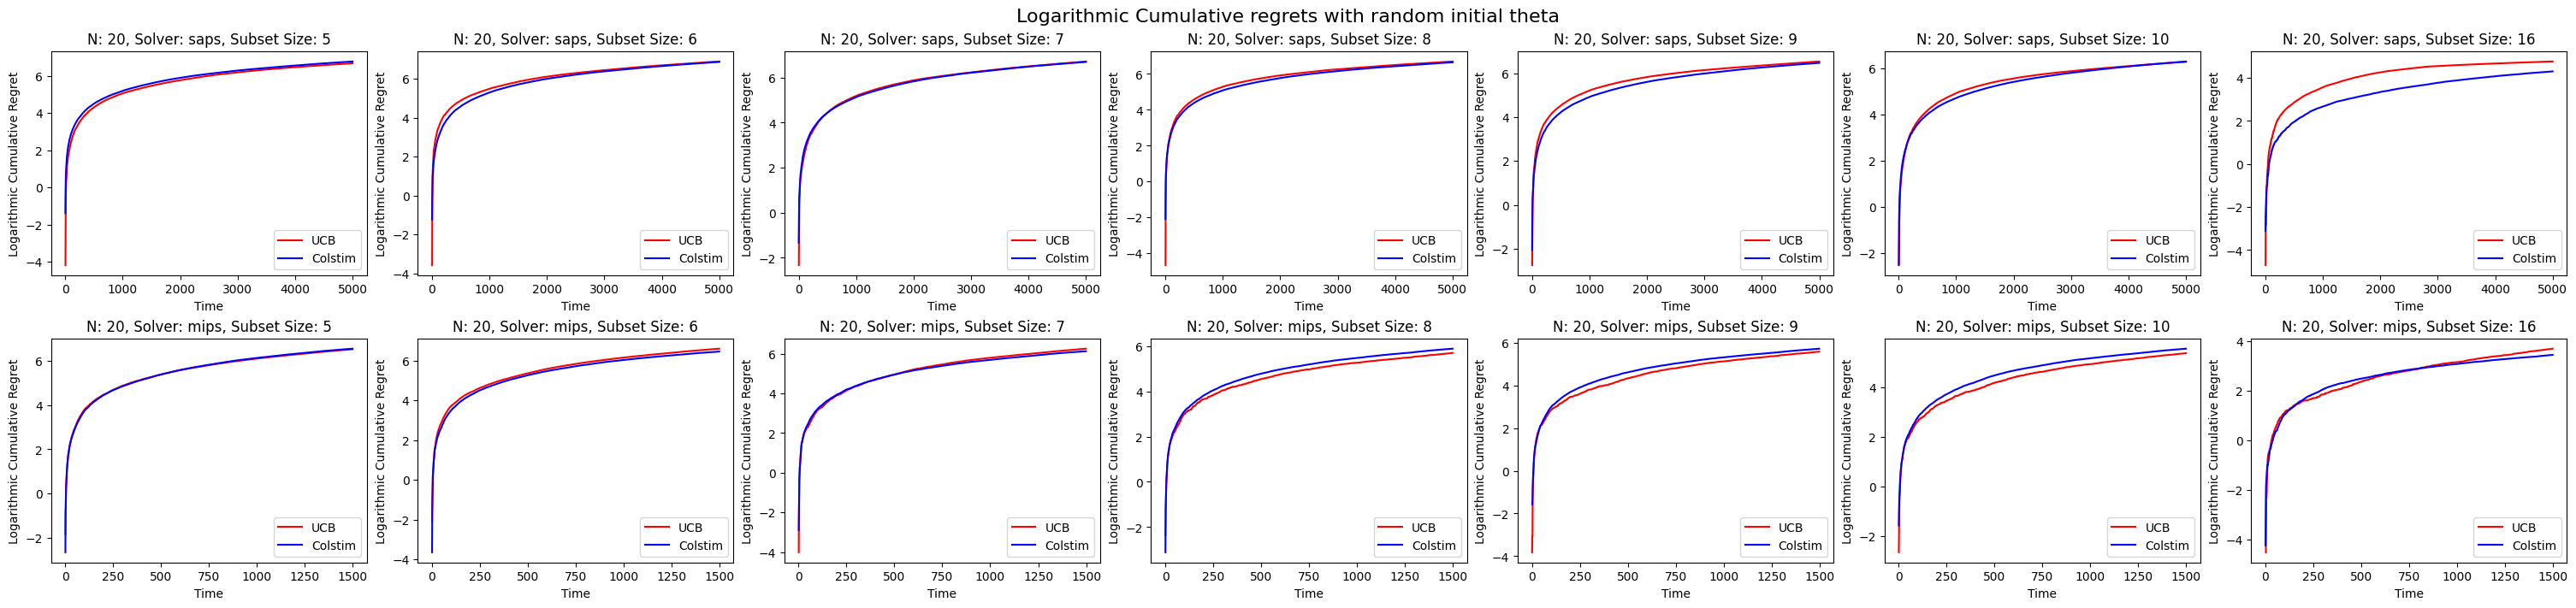

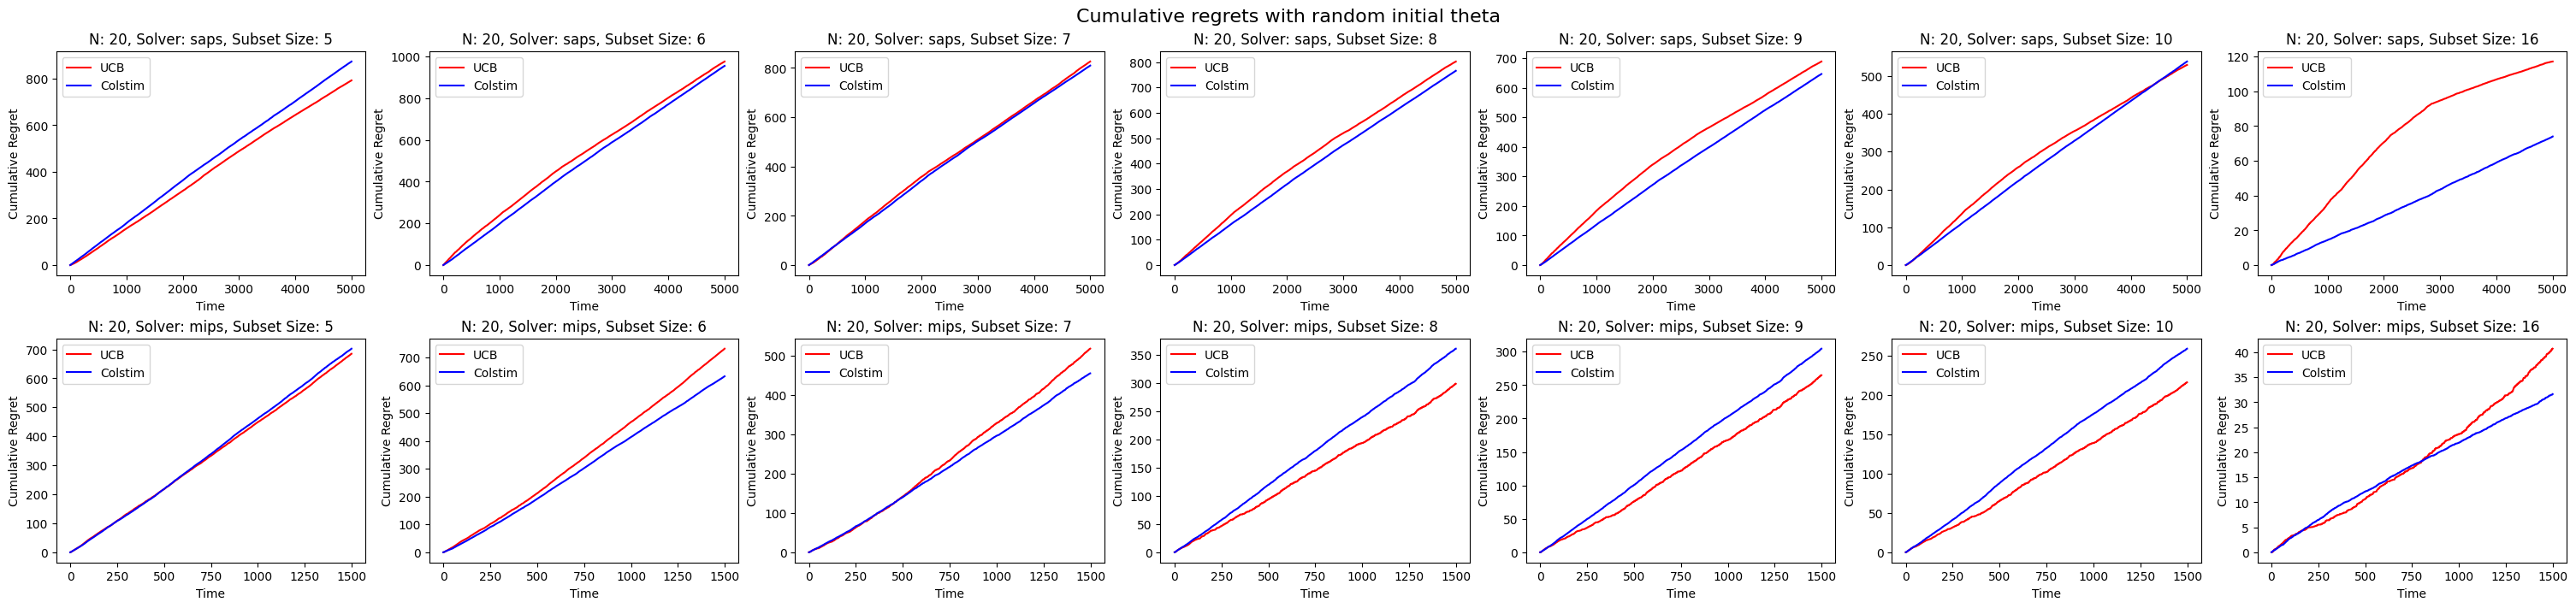

In [2]:
algorithms = ["UCB", "Colstim"]
solvers = [solver.value for solver in Solver]
subset_size = [5, 6, 7, 8, 9, 10, 16]
colors = ["red", "blue"]
directory = "Regret_results"
plot_regret_curves(algorithms, solvers, subset_size, colors, directory)

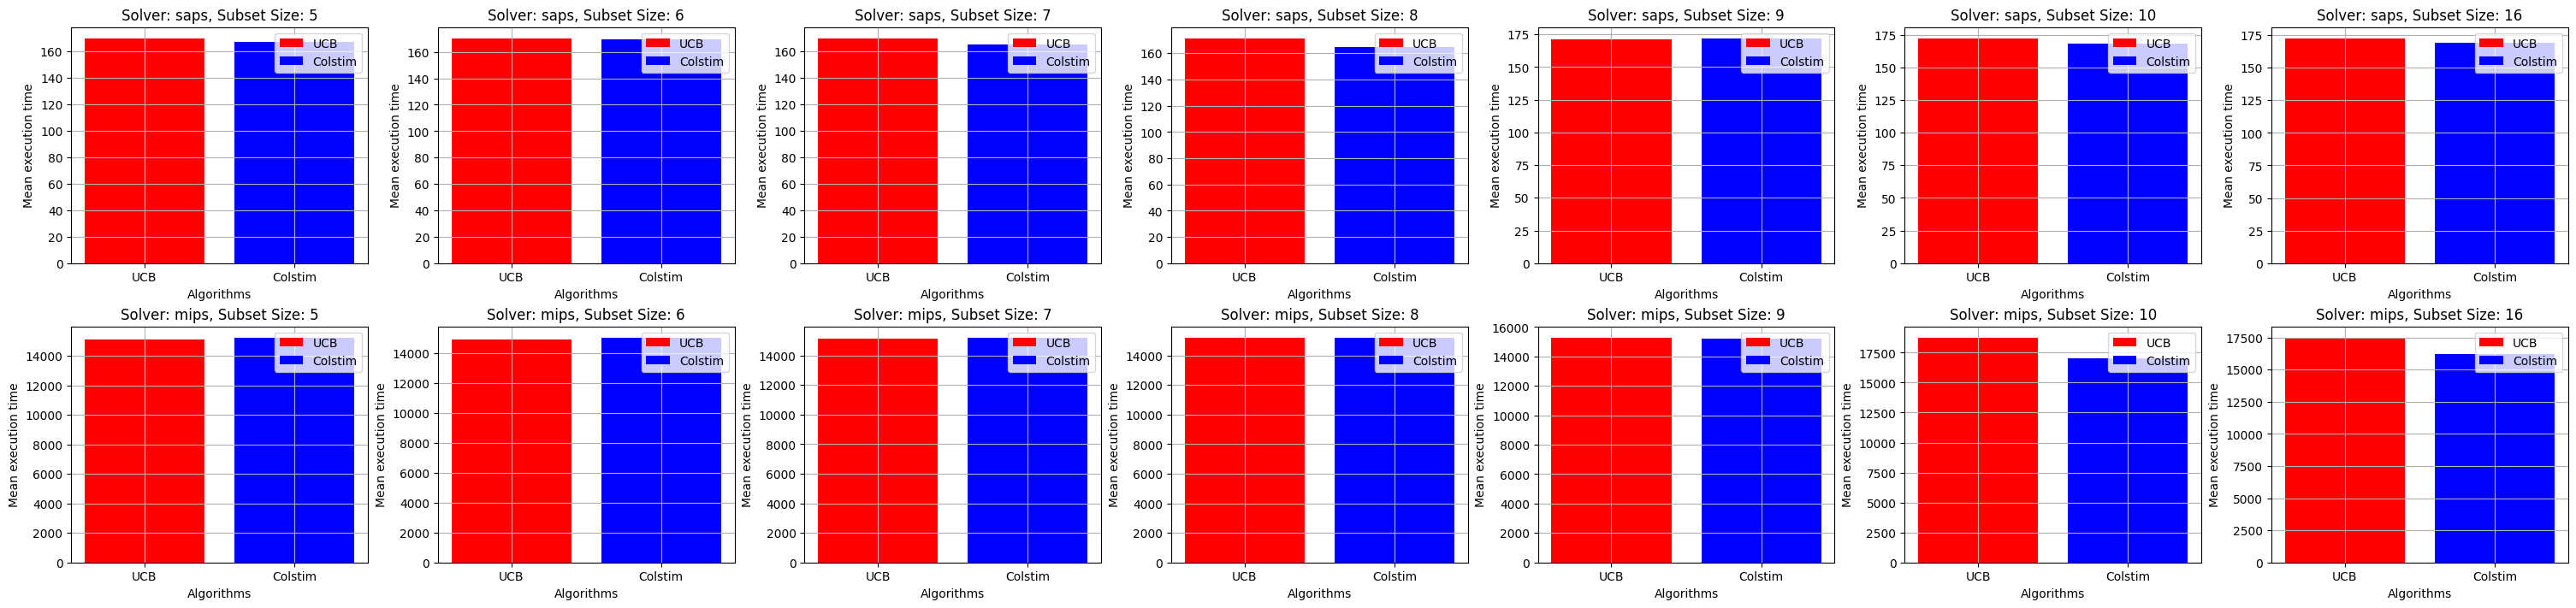

In [3]:
directory = "Execution_times_results"
plot_execution_times(algorithms, solvers, subset_size, colors, directory)

## Plotting results from Theta0

/tmp/ipykernel_26616/1609391087.py:15: RuntimeWarning: divide by zero encountered in log
  ax[solver_index, size_index].plot(np.log(np.mean(cum_reg, axis=0)), color=colors[index], label=f"{algorithm}")


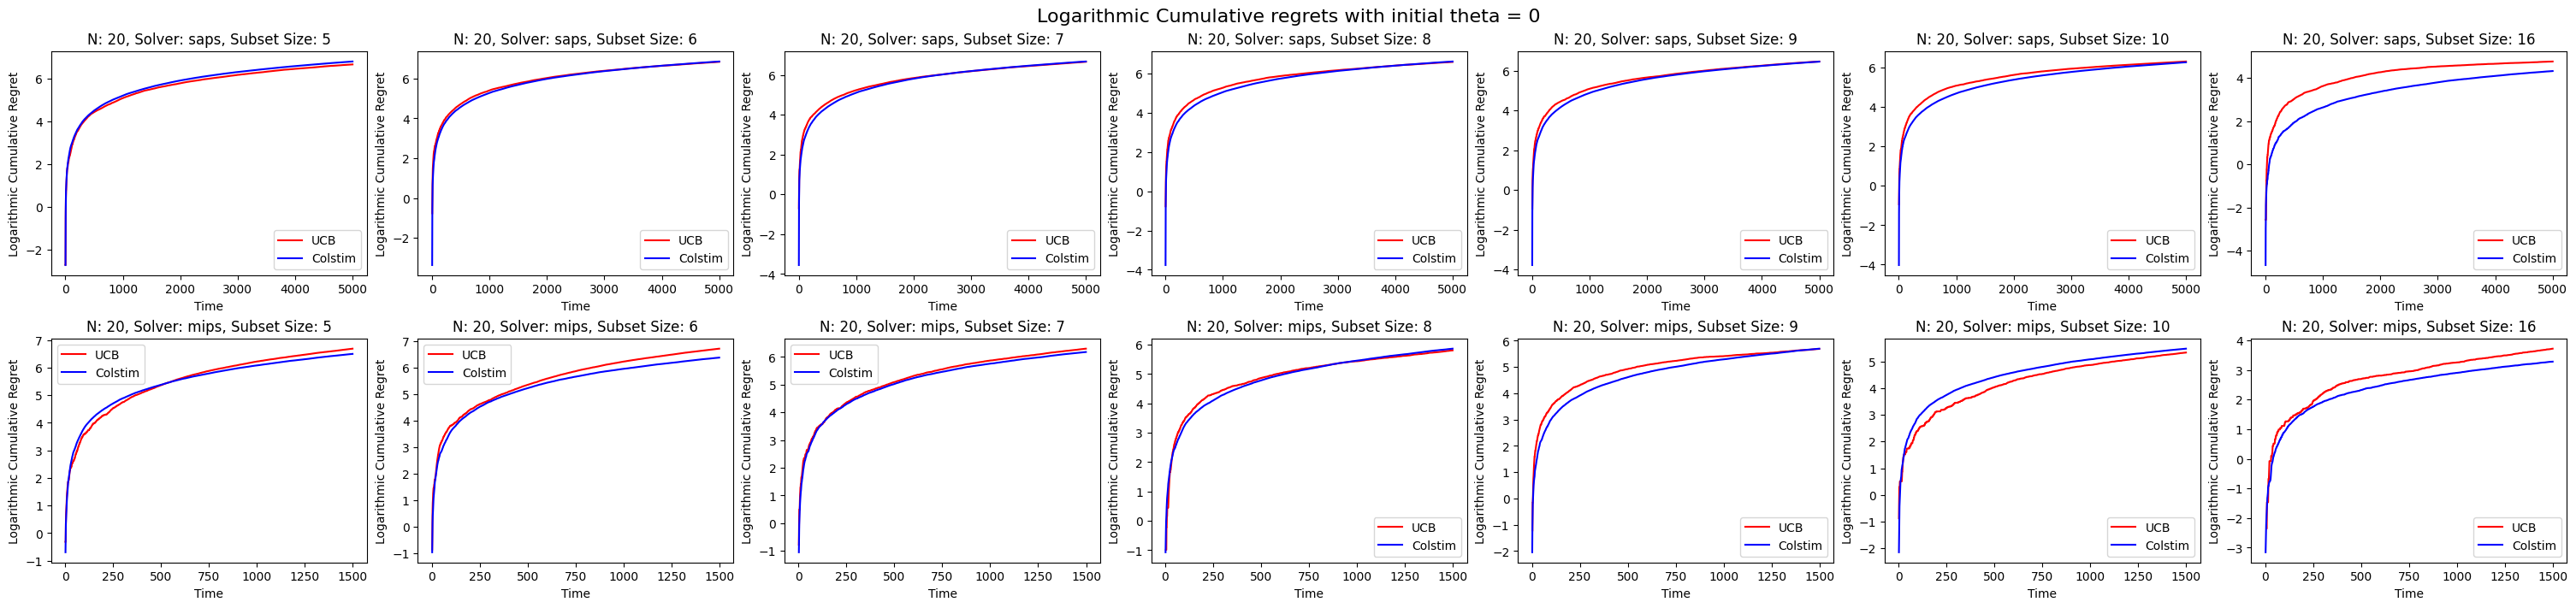

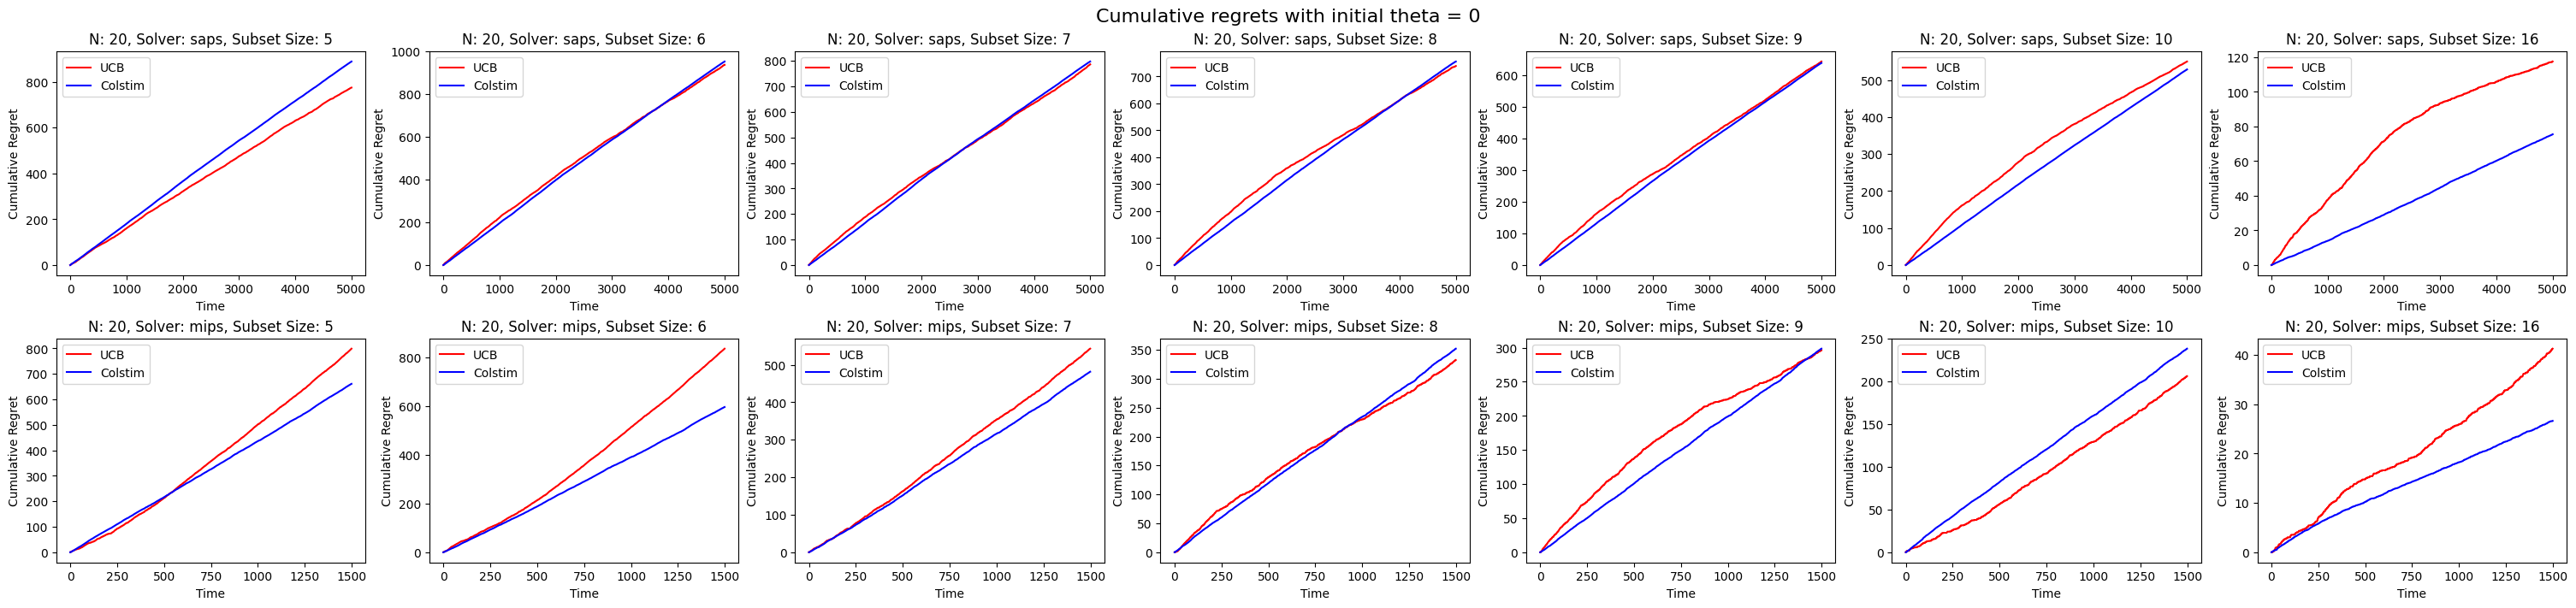

In [4]:
algorithms = ["UCB", "Colstim"]
solvers = [solver.value for solver in Solver]
subset_size = [5, 6, 7, 8, 9, 10, 16]
colors = ["red", "blue"]
directory = "Regret_results_theta0"
plot_regret_curves(algorithms, solvers, subset_size, colors, directory, theta_0=True)

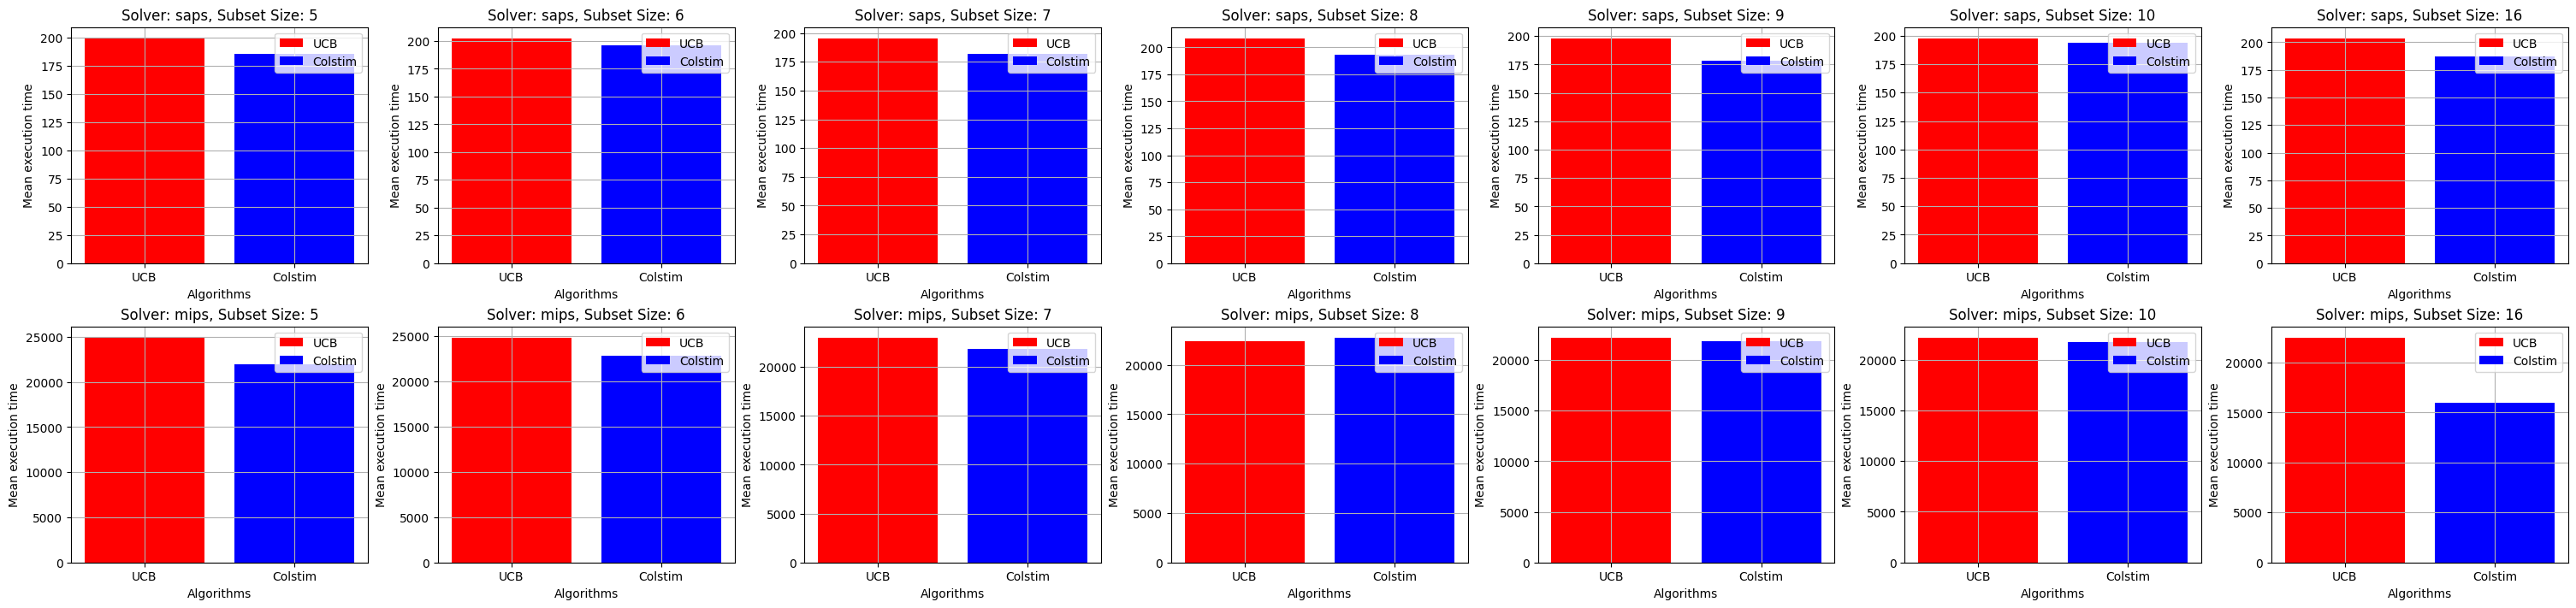

In [5]:
directory = "Execution_times_results_theta0"
plot_execution_times(algorithms, solvers, subset_size, colors, directory)

## Plotting Colstim V2 with theta0

/tmp/ipykernel_66446/1609391087.py:15: RuntimeWarning: divide by zero encountered in log
  ax[solver_index, size_index].plot(np.log(np.mean(cum_reg, axis=0)), color=colors[index], label=f"{algorithm}")


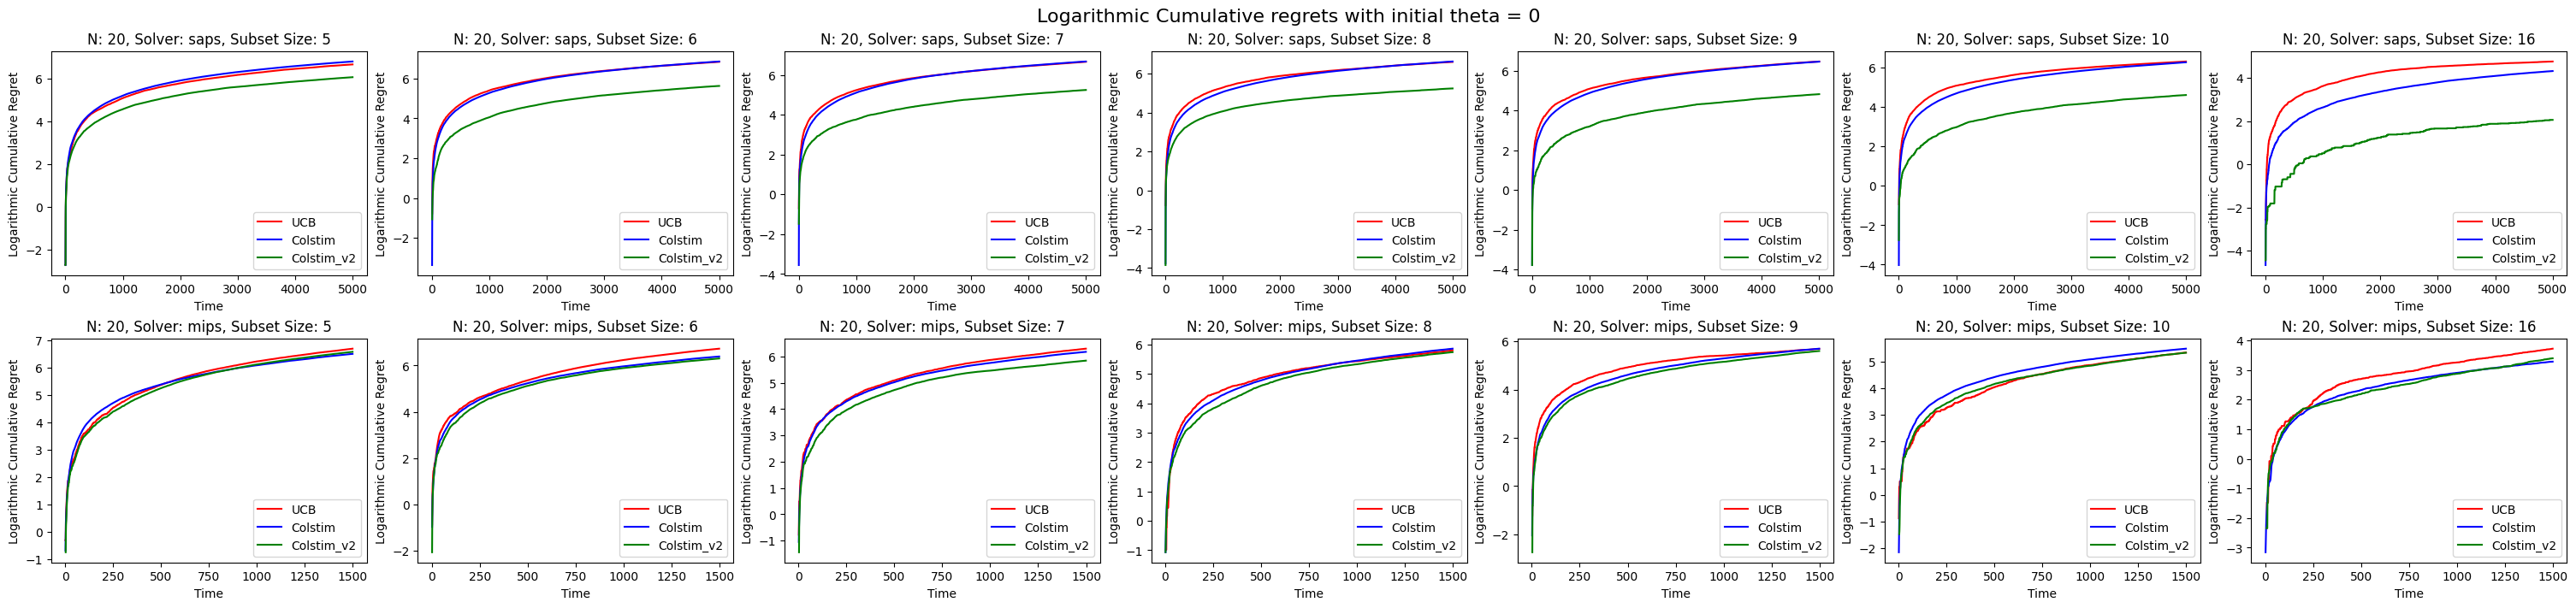

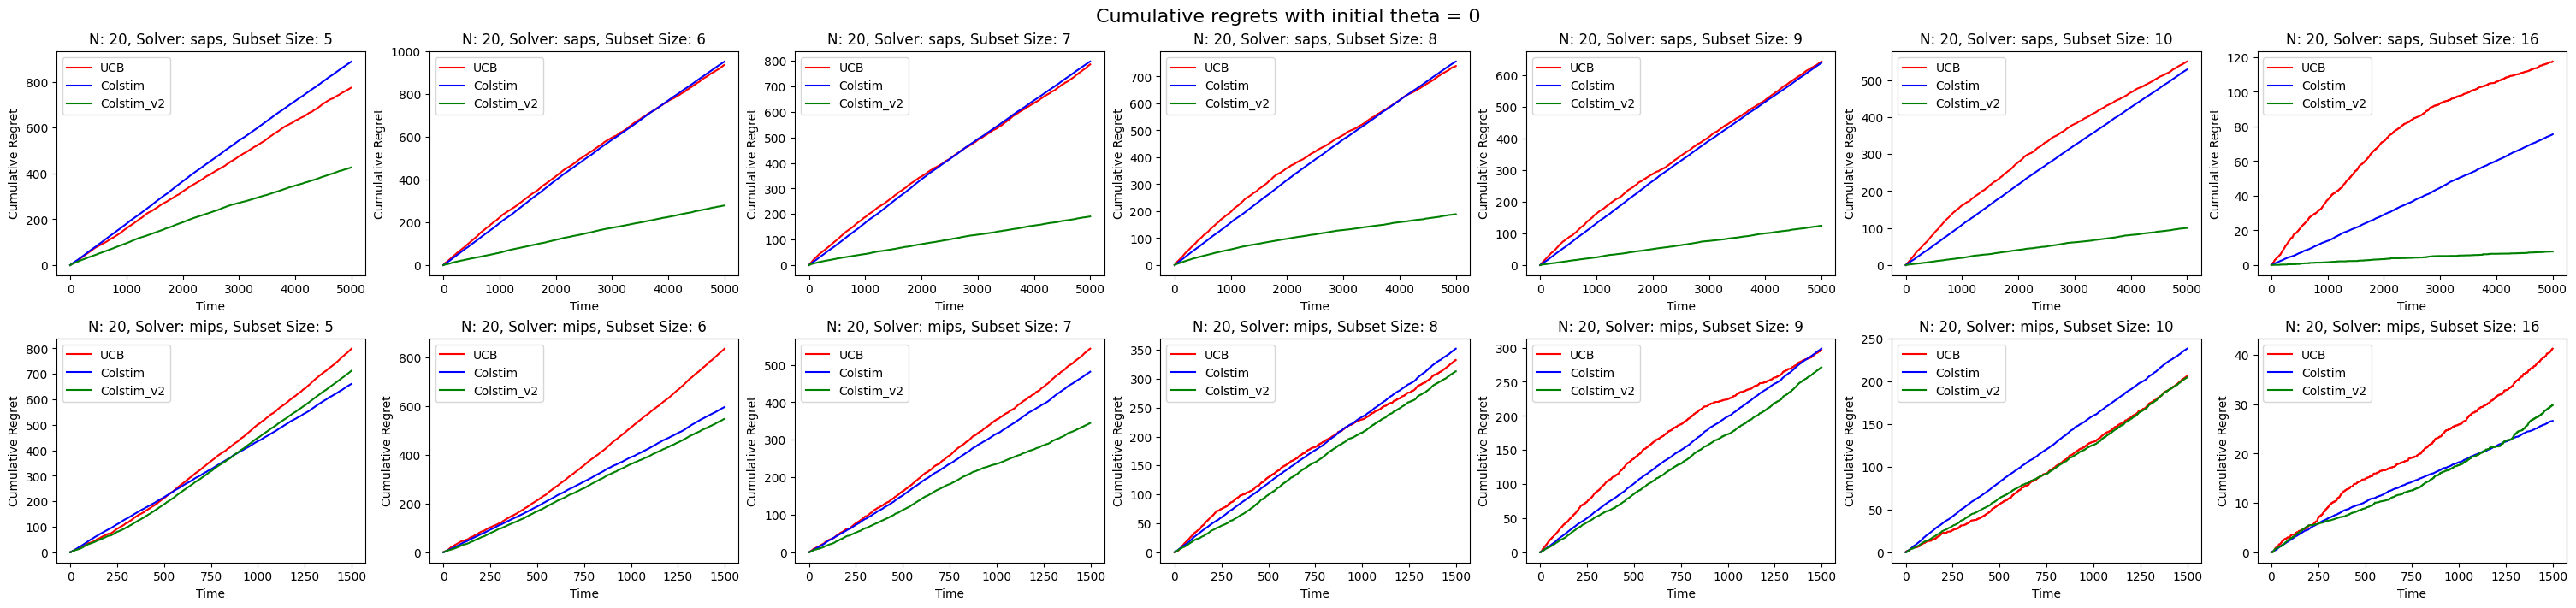

In [10]:
from algorithms import regret_minimizing_algorithms
    
algorithms = [algorithm.__name__ for algorithm in regret_minimizing_algorithms]

solvers = [solver.value for solver in Solver]
subset_size = [5, 6, 7, 8, 9, 10, 16]
colors = ["red", "blue", "green"]
directory = "Regret_results_theta0"
plot_regret_curves(algorithms, solvers, subset_size, colors, directory, theta_0=True)

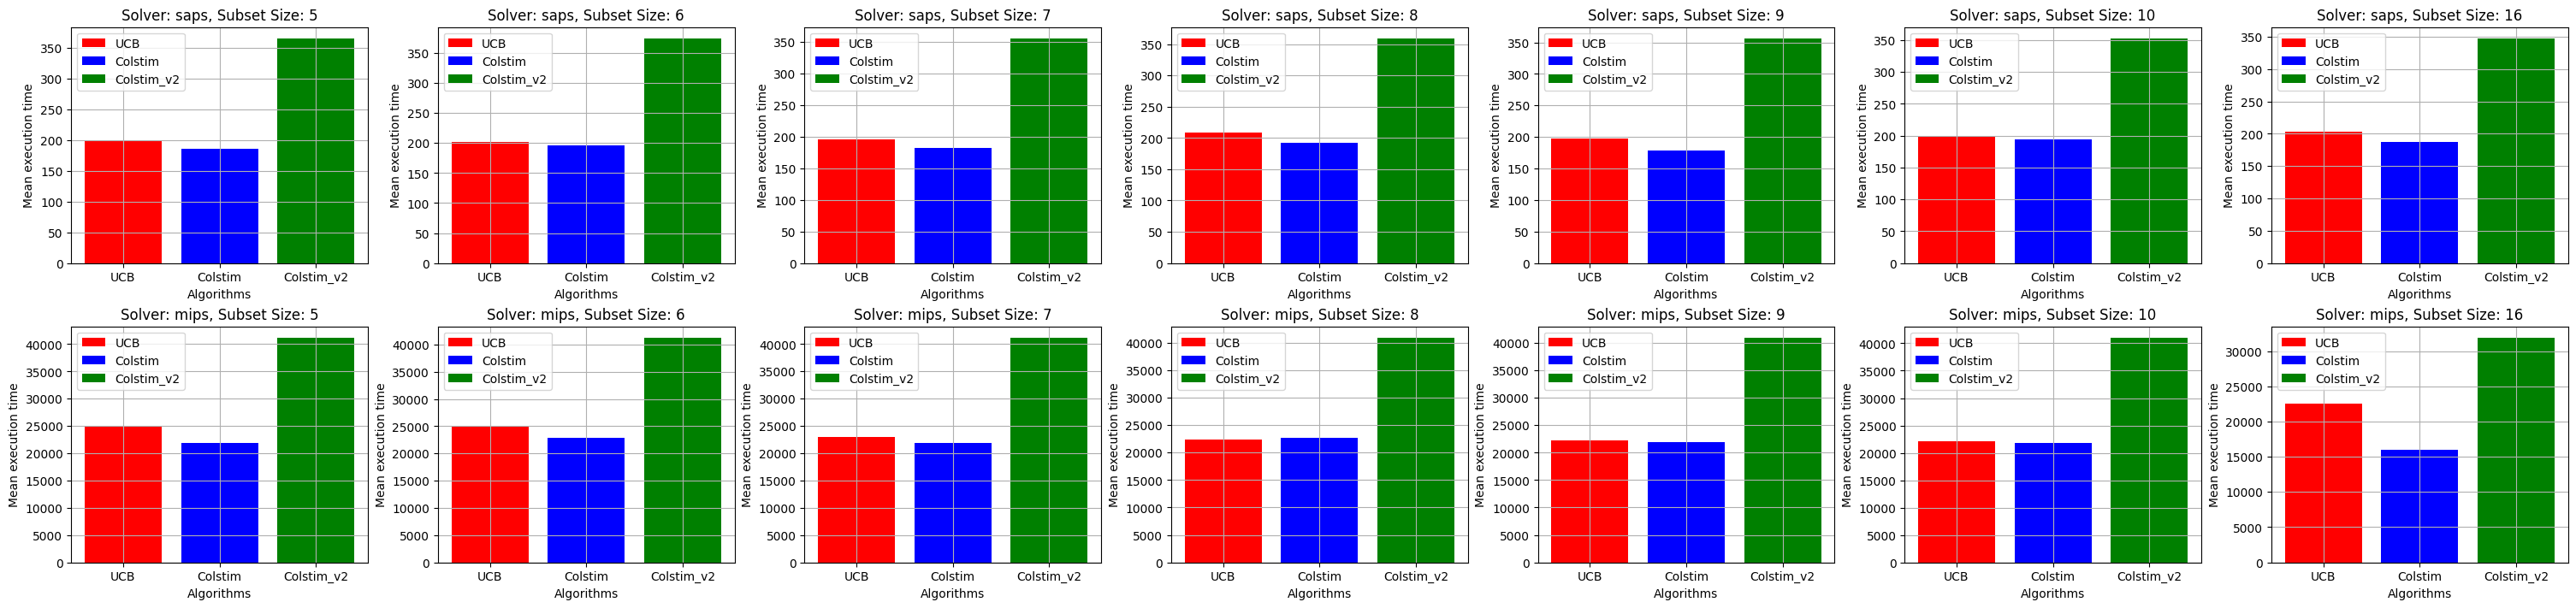

In [12]:
directory = "Execution_times_results_theta0"
plot_execution_times(algorithms, solvers, subset_size, colors, directory)

## Plotting 50 reps

/tmp/ipykernel_96108/1609391087.py:15: RuntimeWarning: divide by zero encountered in log
  ax[solver_index, size_index].plot(np.log(np.mean(cum_reg, axis=0)), color=colors[index], label=f"{algorithm}")


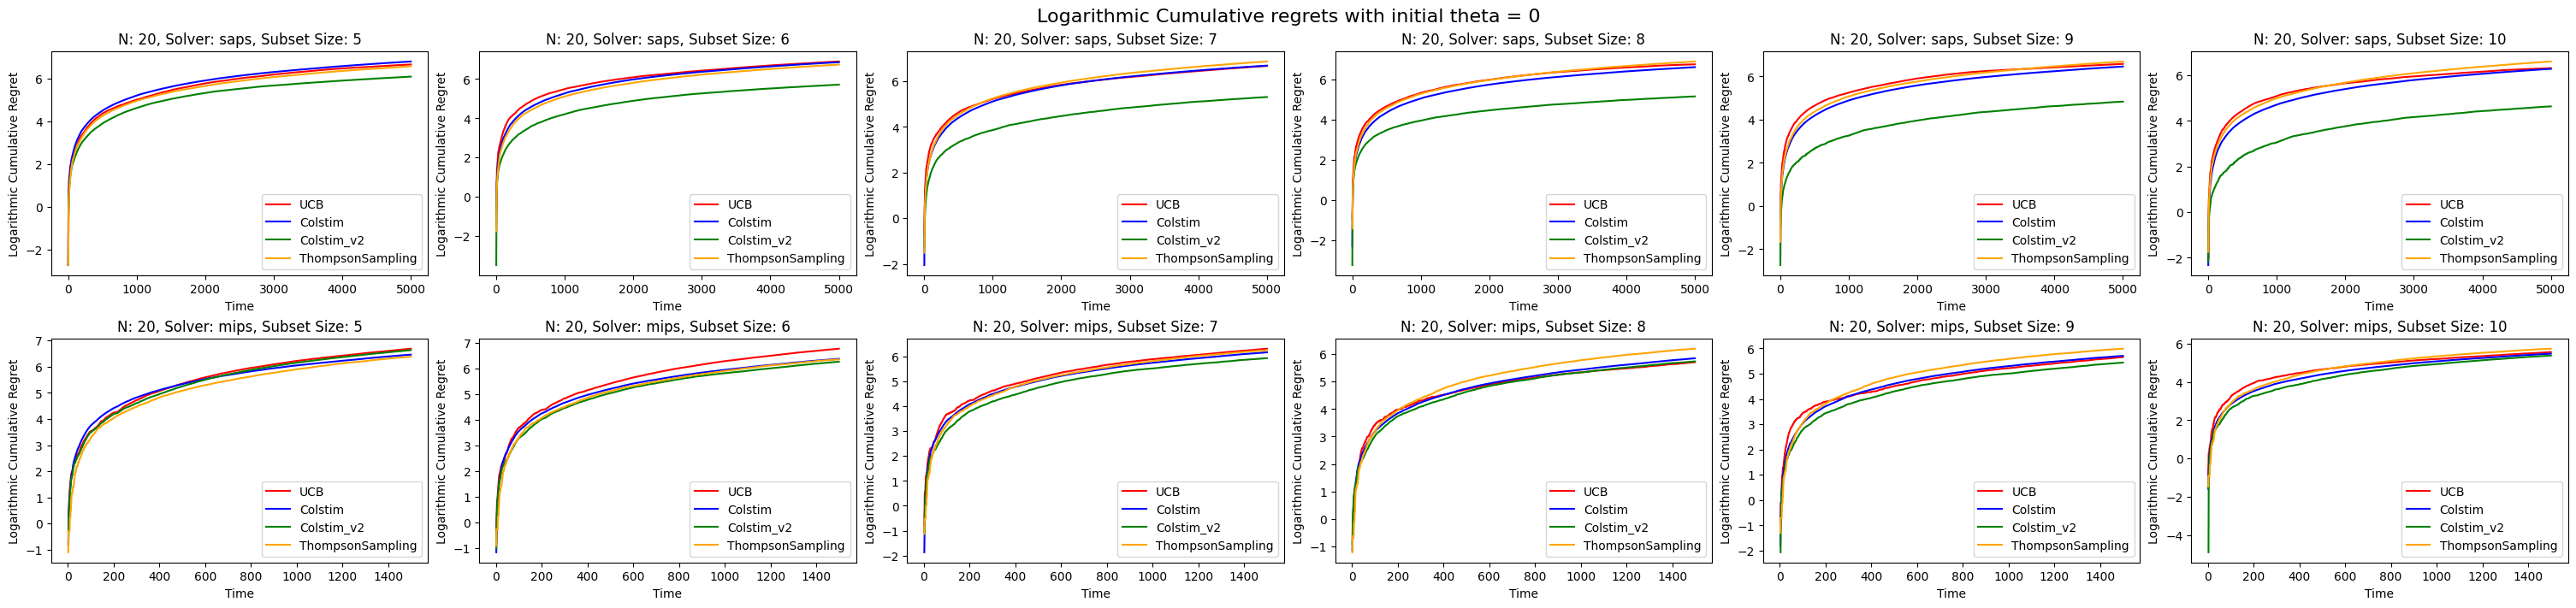

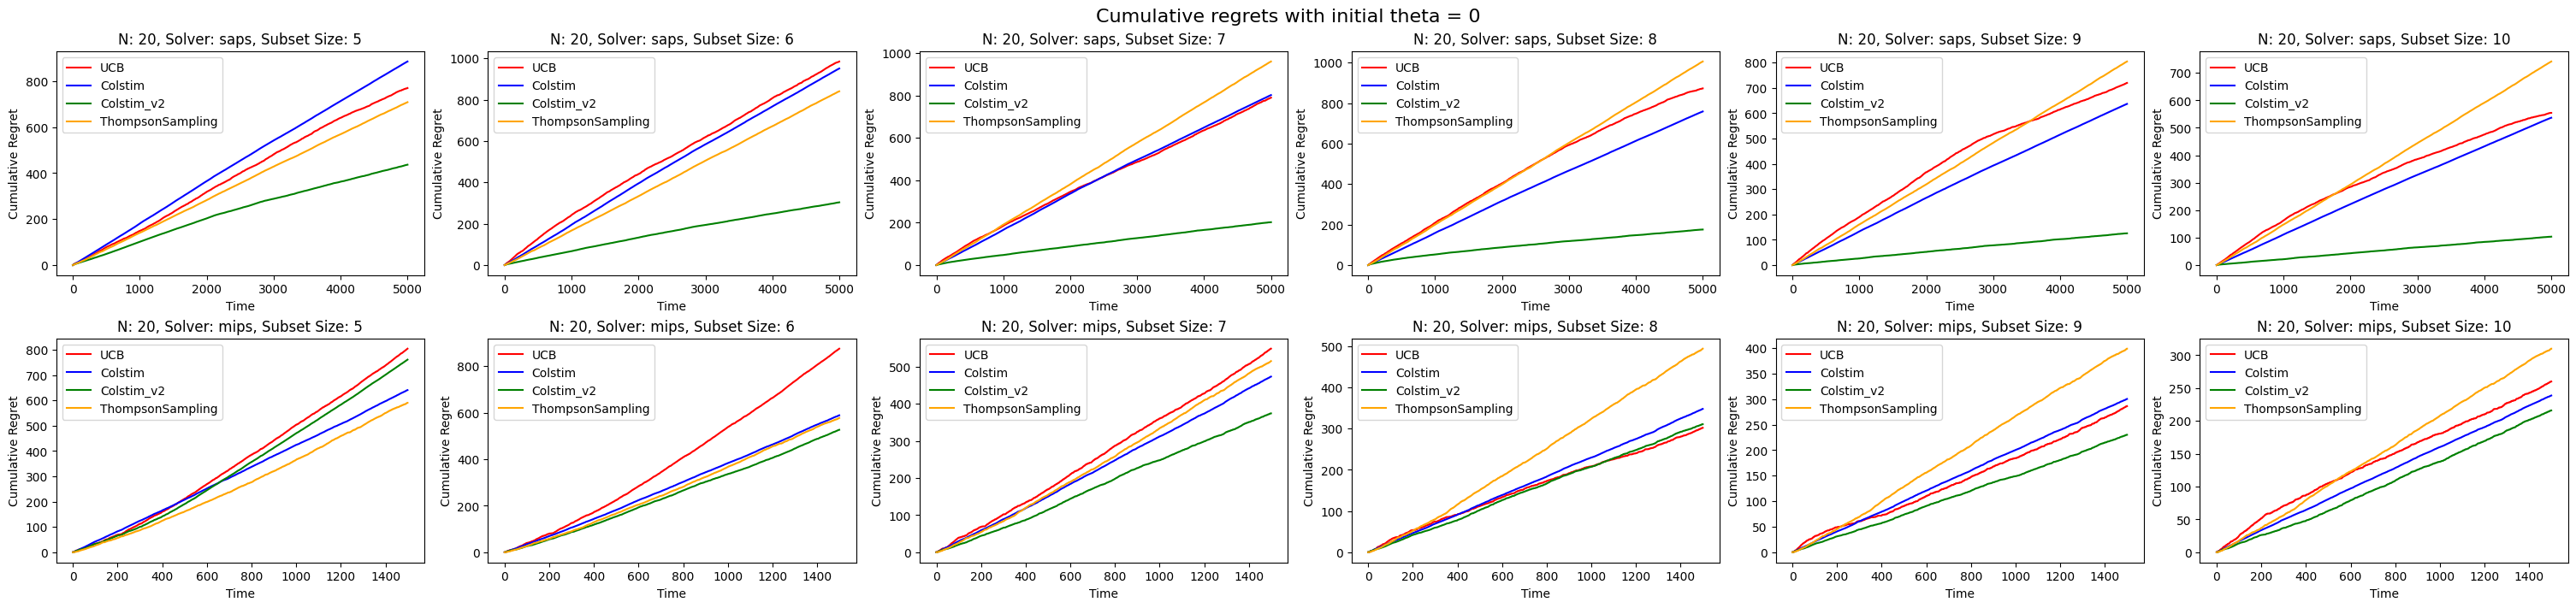

In [3]:
from algorithms import regret_minimizing_algorithms
    
algorithms = [algorithm.__name__ for algorithm in regret_minimizing_algorithms]

solvers = [solver.value for solver in Solver]
subset_size = [5, 6, 7, 8, 9, 10]
colors = ["red", "blue", "green", "orange"]
directory = "Regret_results_theta0_50"
plot_regret_curves(algorithms, solvers, subset_size, colors, directory, theta_0=True)

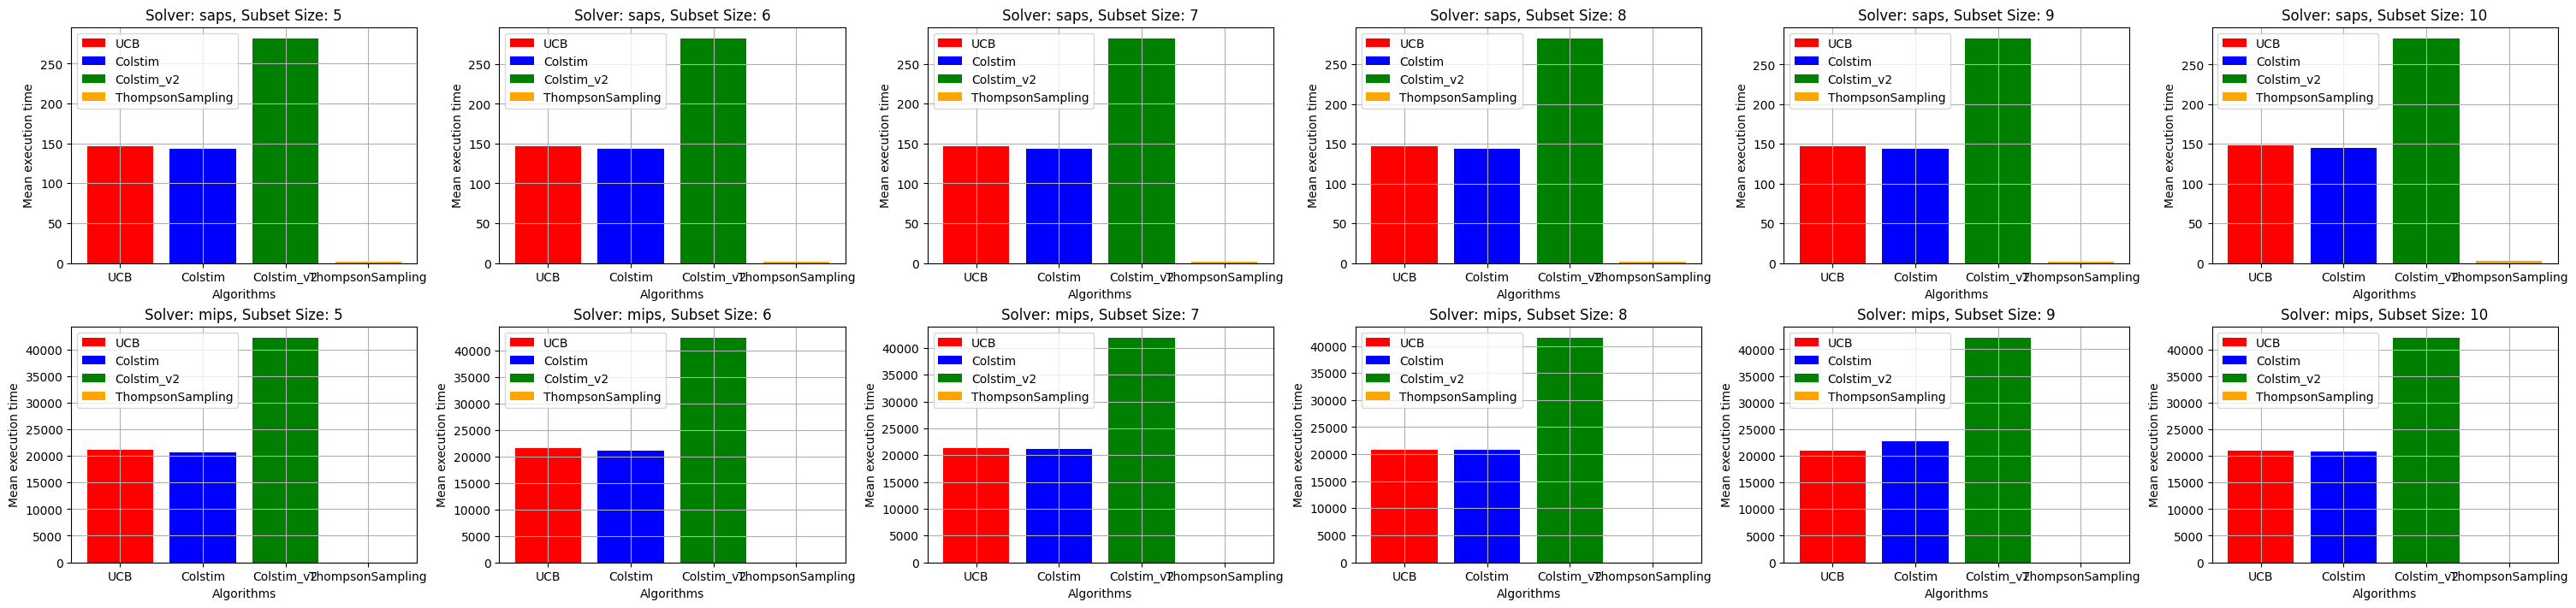

In [5]:
directory = "Execution_times_results_theta0_50"
plot_execution_times(algorithms, solvers, subset_size, colors, directory)

## Concatenate rep of MIPS dataset

In [5]:
for size in [5, 6, 7, 8, 9, 10, 16]:
    execution_time = np.load(f"Execution_times_results_v2/execution_time_Colstim_v2_mips_{size}.npy", allow_pickle=True)
    execution_time_2 = np.load(f"Execution_times_results_v2/execution_time_Colstim_v2_mips_{size}_2.npy", allow_pickle=True)
    execution_time_3 = np.load(f"Execution_times_results_v2/execution_time_Colstim_v2_mips_{size}_3.npy", allow_pickle=True)  
    execution_time_4 = np.load(f"Execution_times_results_v2/execution_time_Colstim_v2_mips_{size}_4.npy", allow_pickle=True)  
    execution_time_con = np.concatenate((execution_time, execution_time_2, execution_time_3, execution_time_4))
    np.save(f"Execution_times_results_v2//execution_time_Colstim_v2_mips_{size}.npy", execution_time_con)

In [8]:
np.load("Execution_times_results_theta0/execution_time_Colstim_v2_mips_5.npy", allow_pickle=True)

array([28246.47454369, 28202.42160515, 28312.66955276, 46781.16721135,
       46801.01410709, 46809.08650008, 46688.39425993, 46576.94707812,
       46793.11589472, 46811.15779342])